# Soil moisture drought index

This notebook is the base of the following figures:

* Figure SPM.6
* Figure 11.18
* Figure 11.19

Author: Mathias Hauser

In [1]:
import warnings

import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplotutils as mpu
import numpy as np
import regionmask
import scipy as sp
import seaborn as sns
import xarray as xr

import conf
from utils import computation, plot, transform, save_figuredata
import data_tables

mpl.rcParams["font.sans-serif"] = "Arial"
mpl.rcParams["figure.dpi"] = 200

In [2]:
warnings.filterwarnings("ignore", "divide by zero encountered in log10")

### AR6 land regions

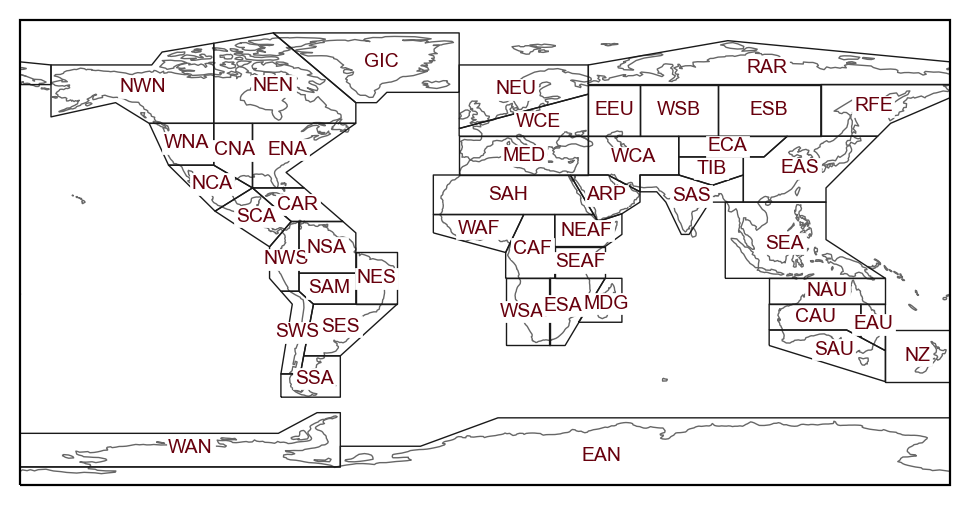

In [3]:
ar6_land = regionmask.defined_regions.ar6.land

text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))

ar6_land.plot(text_kws=text_kws, label="abbrev", line_kws=dict(linewidth=0.5))
None

## Load Data

In [4]:
# global mean temperature
c6_tas = conf.cmip6.load_post_all_concat(varn="tas", postprocess="global_mean")

 -- {'varn': 'tas', 'postprocess': 'global_mean', 'table': 'Amon', 'model': 'IITM-ESM', 'exp': 'ssp370', 'ens': 'r1i1p1f1', 'grid': 'gn', 'ensnumber': 0}: no data for 2099 - 2099 (1850..2098)


In [5]:
# annual mean SM
c6_mrso_no_anom = conf.cmip6.load_post_all_concat(
    varn="mrso", postprocess="sm_annmean_regrid", anomaly="no_anom"
)

-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'CAMS-CSM1-0', 'ens': 'r2i1p1f1', 'grid': 'gn', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'EC-Earth3', 'ens': 'r4i1p1f1', 'grid': 'gr', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'GISS-E2-1-G', 'ens': 'r1i1p1f2', 'grid': 'gn', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'CAMS-CSM1-0', 'ens': 'r2i1p1f1', 'grid': 'gn', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'GISS-E2-1-G', 'ens': 'r1i1p1f2', 'grid': 'gn', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess

In [6]:
# seasonal mean SM
c6_mrso_seas_no_anom_orig = conf.cmip6.load_post_all(
    varn="mrso",
    postprocess="sm_regrid_seas_mean_cat",
    anomaly="no_anom",
    year_mean=False,
)

### reshape seasonal SM

from `time` to `season x year`

In [7]:
def _to_seasonal(ds):

    year = ds.time.dt.year.data
    season = ds.time.dt.season.data

    # assign new coords
    ds = ds.assign_coords(year=("time", year), season=("time", season))

    # reshape the array to (..., "season", "year")
    return ds.set_index(time=("year", "season")).unstack("time")


c6_mrso_seas_no_anom = computation.process_datalist(
    _to_seasonal, c6_mrso_seas_no_anom_orig
)

## Get mask_3D for ar6.land

In [8]:
# get random model for grid (all are the same)
ds = c6_mrso_no_anom[0][0]

# ====

ar6_land = regionmask.defined_regions.ar6.land
tra = transform.RegionAverage("mrso", ar6_land, land_only=False)
mask_3D = tra._get_mask3D(ds)

# remove some regions
# - Global mean (region -4)
# - Ocean mean & Ocean mean (region -2)
# - Land (region -2)
# - Land w/o Antarctica (region -1)
# - Greenland/Iceland (region 0)
# - Caribbean (region 8)
mask_3D = mask_3D.drop_sel(region=[-4, -3, -2, -1, 0, 8])

## Helper Functions

In [9]:
def quantile_via_probplot(da, q, dim):
    """find quantile via probability plot (q-q plot)

    Parameters
    ----------
    da : DataArray
        DataArray to estimate quantile from
    q : float
        Quantile in 0..1
    dim : str
        Dimension to calculate the quantile from

    Returns
    -------
    thresh : DataArray
        quantile threshold via probplot

    """

    # copy so we can overwrite the values inplace
    da = da.copy(deep=True)

    # get the theoretical quantiles
    example = np.arange(len(da[dim]))
    osm, __ = sp.stats.probplot(example, fit=False)

    # find the inverse of the cdf
    # i.e. there are q * 100 % values below x
    x = sp.stats.norm.ppf(q)

    # interpolate to x -> get indices and frac
    v = np.interp(x, osm, example)
    i_l = np.floor(v).astype(int)
    i_u = np.ceil(v).astype(int)
    frac = v % 1

    # sort the array and interpolate to x
    da.values = np.sort(da.values, axis=da.get_axis_num(dim))

    # manual interpolation
    da = da.isel({dim: i_l}) * (1 - frac) + da.isel({dim: i_u}) * frac

    return da

In [10]:
def compute_anomaly(data, clim, how):
    """compute anomaly wrt a climatology, aligning on model, exp & ens

    Parameters
    ----------
    data : dict of DataArrays
        data keys indicate warming levels
    clim : str
        Name of climatology to use in data
    how : "fraction" | "relative"
        How to calculate the change

    """

    levels = list(data.keys())
    levels.remove(clim)

    clim = data[clim]
    clim = clim.set_index(mod_ens=("model", "exp", "ens"))

    out = dict()

    for level in levels:

        d = data[level]
        d = d.set_index(mod_ens=("model", "exp", "ens"))

        if how == "relative":
            d = (d - clim) / clim * 100
        elif how == "fraction":
            d = d / clim
        elif how == "absolute":
            d = d - clim

        d = d.reset_index("mod_ens")

        out[level] = d

    return out


def compute_anomaly_and_mmm(data, clim, how):
    """calculate change and the multi model median"""

    anom = compute_anomaly(data, clim, how=how)
    keys = anom.keys()
    mmm_anom = {k: anom[k].median("mod_ens") for k in keys}

    return anom, mmm_anom

## Normalize SM data (z-score)


In [11]:
c6_mrso = computation.process_datalist(
    computation.calc_anomaly, c6_mrso_no_anom, start=1850, end=1900, how="norm"
)

In [12]:
c6_mrso_seas = computation.process_datalist(
    computation.calc_anomaly, c6_mrso_seas_no_anom, start=1850, end=1900, how="norm"
)

## Frequency

### Helper fuctions

In [13]:
def _below_thresh(da, meta, thresh_all):
    """set data below threshold to True"""

    # find the threshold for the specific model
    dl = computation.select_by_metadata(thresh_all, **meta)

    if len(dl) == 0:
        return []

    # make sure exactly one is found
    assert len(dl) == 1, meta

    thresh, meta = dl[0]

    below_thres = da < thresh

    # mask ocean & ice gridpoints again
    return below_thres.where(~da.isnull().all("year"))

In [14]:
def calculate_drought_frequency(data, n_years, clim):

    if clim == "hist":

        # get the data from 1850-1900 (raw)
        data_clim = computation.time_average(
            data, 1850, 1900, reduce=None, as_datalist=True
        )

    elif clim == "0.84":
        data_clim = computation.at_warming_level(
            c6_tas, data, 0.84, reduce=None, n_years=n_years, as_datalist=True
        )
        
    else:
        raise ValueError("")

    # compute the threshold (10th quantile)
    thresh_clim = computation.process_datalist(
        quantile_via_probplot, data_clim, q=0.1, dim="year"
    )

    # set SM below the threshold to 1 (all years)
    data_below_thresh = computation.process_datalist(
        _below_thresh, data, pass_meta=True, thresh_all=thresh_clim
    )

    # find the mean drought freq for 1850-1900
    drough_freq_clim = computation.time_average(data_below_thresh, 1850, 1900)

    warming_levels = [0.84, 1.0, 1.5, 2.0, 3.0, 4.0]

    # find the mean drought freq for the warming levels
    drought_freq = computation.at_warming_levels_dict(
        c6_tas, data_below_thresh, warming_levels=warming_levels, n_years=n_years
    )

    # assign the climatological period to the dict
    drought_freq["clim"] = drough_freq_clim

    return drought_freq

### Calculate drought frequncy

- units: -
- `n_year_below_thresh / n_years`

#### Annual mean

In [15]:
drought_freq_hist_20 = calculate_drought_frequency(c6_mrso, n_years=20, clim="hist")

In [16]:
drought_freq_hist_30 = calculate_drought_frequency(c6_mrso, n_years=30, clim="hist")

In [17]:
# using 30 years reduces the numbers of 0s considerably
# -> use 30 years from here on

print((drought_freq_hist_20["4.0"] == 0).sum().item())
print((drought_freq_hist_30["4.0"] == 0).sum().item())

49435
40501


In [18]:
drought_freq_084_30 = calculate_drought_frequency(c6_mrso, n_years=30, clim="0.84")

#### Seasonal

In [19]:
seas_drought_freq_hist_30 = calculate_drought_frequency(
    c6_mrso_seas, n_years=30, clim="hist"
)

In [20]:
seas_drought_freq_084_30 = calculate_drought_frequency(
    c6_mrso_seas, n_years=30, clim="0.84"
)

### Calculate drought frequency anomaly

#### Annual mean

In [21]:
drought_freq_wrt_clim, drought_freq_wrt_clim_mmm = compute_anomaly_and_mmm(
    drought_freq_hist_30, "clim", "fraction"
)

In [22]:
drought_freq_wrt_084, drought_freq_wrt_084_mmm = compute_anomaly_and_mmm(
    drought_freq_084_30, "0.84", "fraction"
)

#### Seasonal

In [23]:
seas_drought_freq_wrt_clim, seas_drought_freq_wrt_clim_mmm = compute_anomaly_and_mmm(
    seas_drought_freq_hist_30, "clim", "fraction"
)

In [24]:
seas_drought_freq_wrt_084, seas_drought_freq_wrt_084_mmm = compute_anomaly_and_mmm(
    seas_drought_freq_084_30, "0.84", "fraction"
)

### Plot the change in frequency

In [25]:
# helper functions


def log10(dta):

    dta = dta
    dta = np.log10(dta)
    # log(0) will be -inf set to -5 (i.e. very small)
    return dta.where(~np.isinf(dta), -5)


def format_cbar(cbar):
    # cbar is in log10 units
    # adapt the ticklabels
    levels = np.array([0.125, 0.25, 0.5, 1, 2, 4, 8])
    levels_log = np.log10(levels)
    cbar.set_ticks(levels_log)
    levels = np.array(["0.125", "0.25", "0.5", "1", "2", "4", "8"])
    cbar.set_ticklabels(levels)

### Extract and convert data for plots

- only the GWL we need
- calculate log10 to be symmetric around 1
- extract seasons

In [26]:
w_levels = ["1.5", "2.0", "4.0"]

drought_freq_wrt_clim_for_plot = [log10(drought_freq_wrt_clim[wl]) for wl in w_levels]


seas_drought_freq_wrt_clim_for_plot = dict()

for season in ["DJF", "MAM", "JJA", "SON"]:

    seas_drought_freq_wrt_clim_for_plot[season] = [
        log10(seas_drought_freq_wrt_clim[wl].sel(season=season)) for wl in w_levels
    ]

In [27]:
drought_freq_wrt_084_for_plot = [log10(drought_freq_wrt_084[wl]) for wl in w_levels]

seas_drought_freq_wrt_084_for_plot = dict()

for season in ["DJF", "MAM", "JJA", "SON"]:

    seas_drought_freq_wrt_084_for_plot[season] = [
        log10(seas_drought_freq_wrt_084[wl].sel(season=season)) for wl in w_levels
    ]

#### Plots

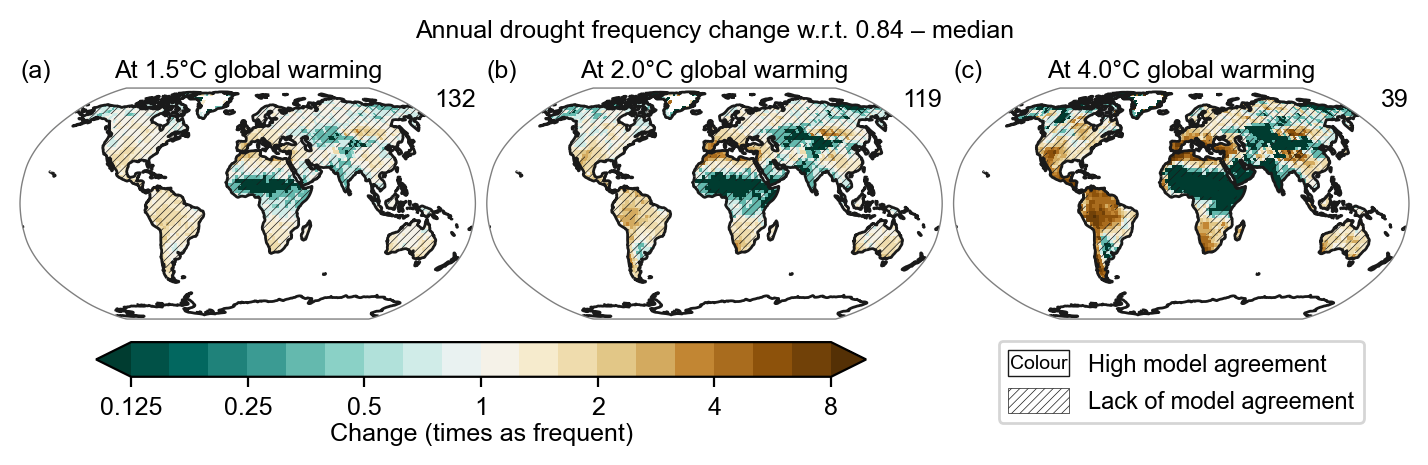

In [28]:
levels = np.linspace(np.log10(0.125), np.log10(8), num=19)

cbar = plot.at_warming_level_one(
    drought_freq_wrt_084_for_plot,
    "Change (times as frequent)",
    "Annual drought frequency change w.r.t. 0.84",
    levels=levels,
    average="median",
    mask_ocean=True,
    cmap="BrBG_r",
    hatch_simple=0.8,
    add_legend=True,
)

format_cbar(cbar)

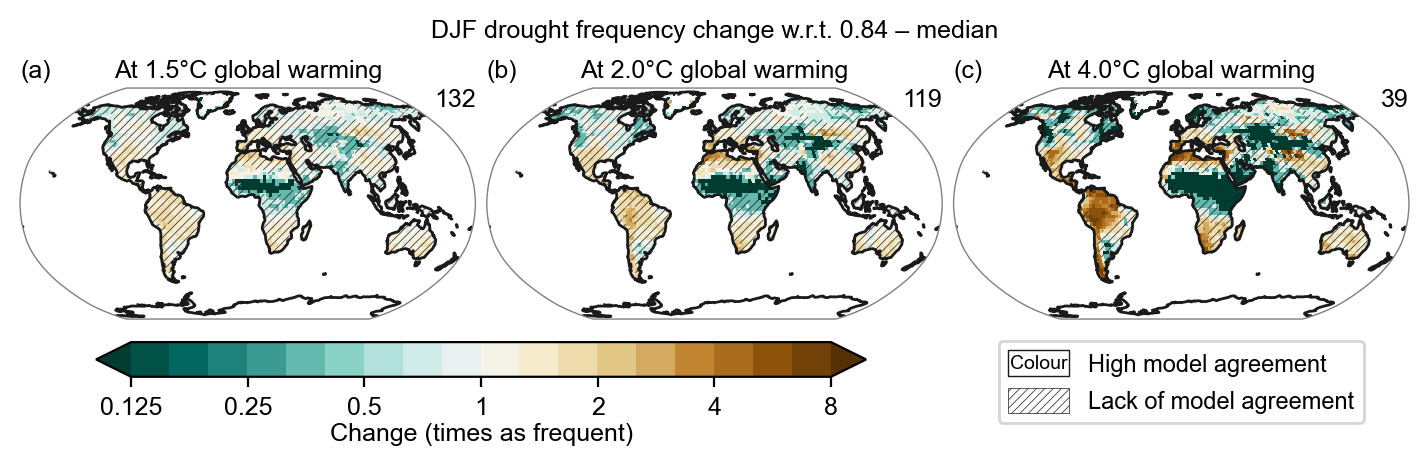

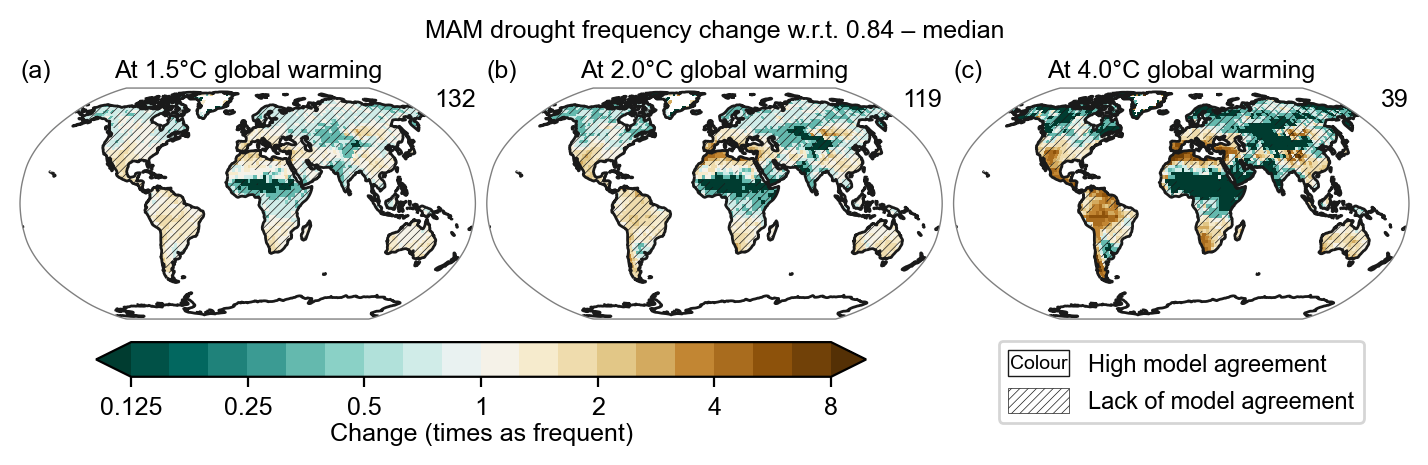

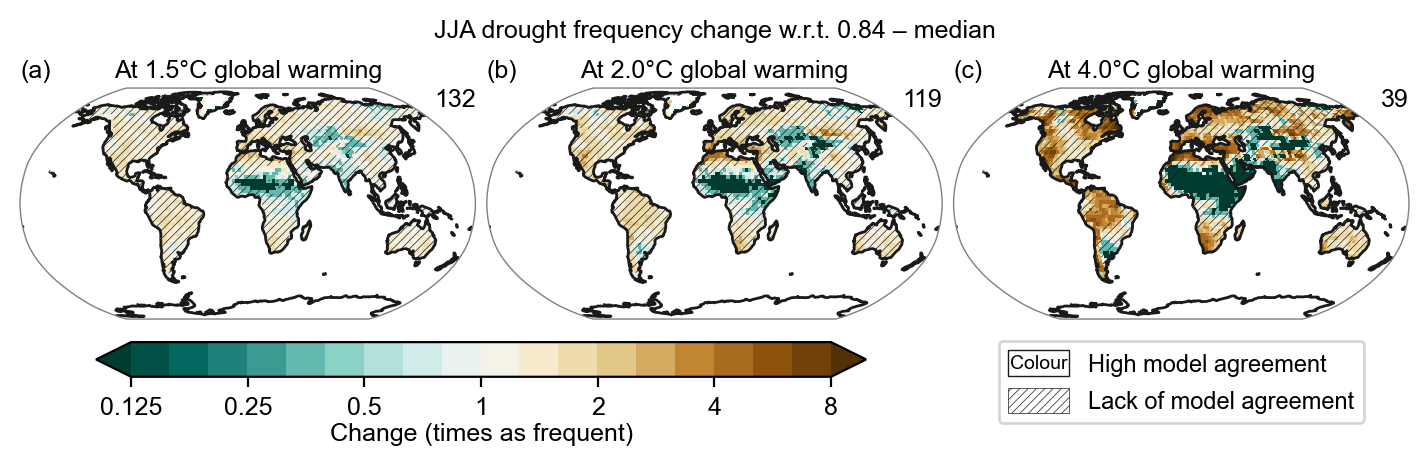

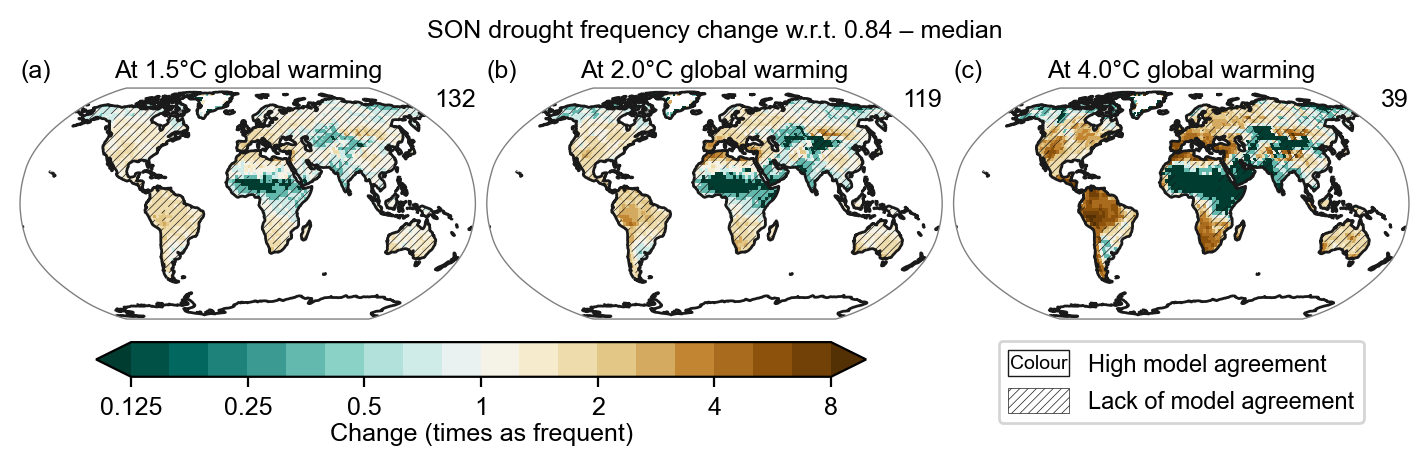

In [29]:
for season in ["DJF", "MAM", "JJA", "SON"]:

    levels = np.linspace(np.log10(0.125), np.log10(8), num=19)

    cbar = plot.at_warming_level_one(
        seas_drought_freq_wrt_084_for_plot[season],
        "Change (times as frequent)",
        f"{season} drought frequency change w.r.t. 0.84",
        levels=levels,
        average="median",
        mask_ocean=True,
        cmap="BrBG_r",
        hatch_simple=0.8,
        add_legend=True,
    )

    format_cbar(cbar)

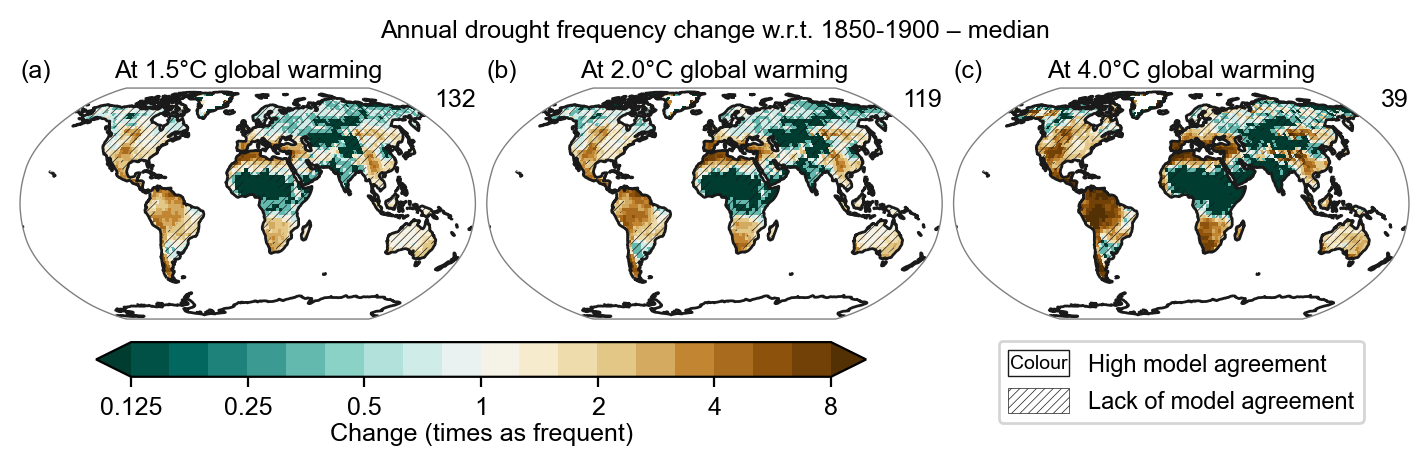

In [30]:
levels = np.linspace(np.log10(0.125), np.log10(8), num=19)

cbar = plot.at_warming_level_one(
    drought_freq_wrt_clim_for_plot,
    "Change (times as frequent)",
    "Annual drought frequency change w.r.t. 1850-1900",
    levels=levels,
    average="median",
    mask_ocean=True,
    cmap="BrBG_r",
    hatch_simple=0.8,
    add_legend=True,
)

format_cbar(cbar)

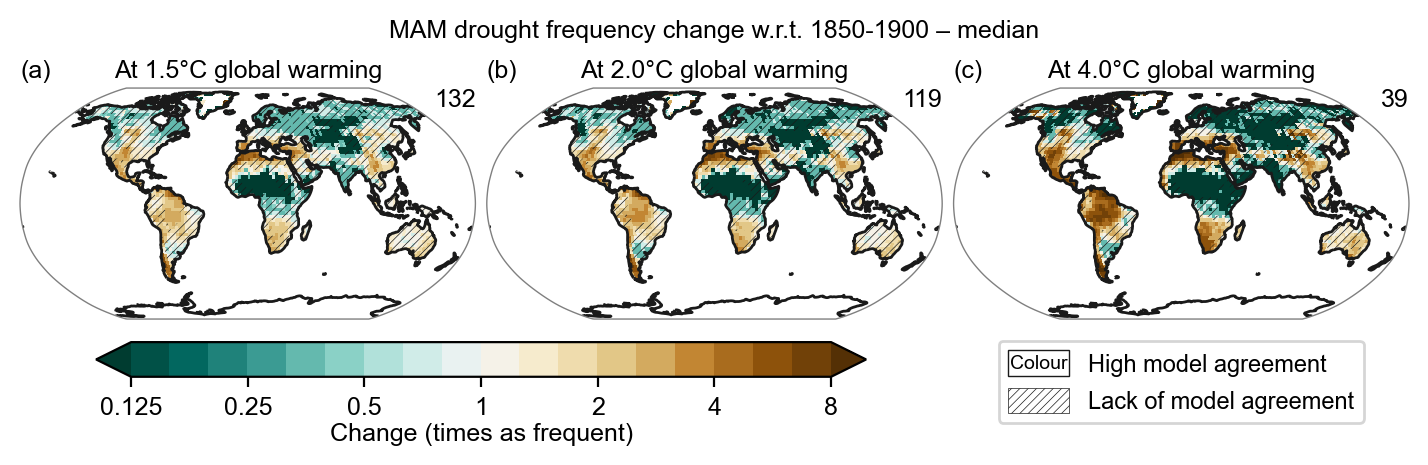

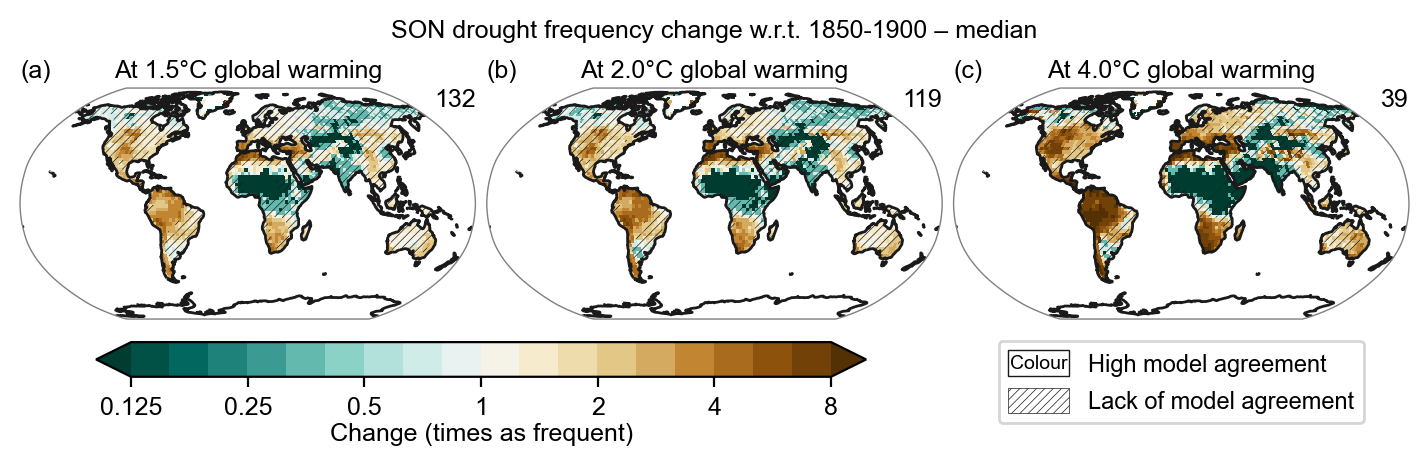

In [31]:
for season in ["MAM", "SON"]:

    levels = np.linspace(np.log10(0.125), np.log10(8), num=19)

    cbar = plot.at_warming_level_one(
        seas_drought_freq_wrt_clim_for_plot[season],
        "Change (times as frequent)",
        f"{season} drought frequency change w.r.t. 1850-1900",
        levels=levels,
        average="median",
        mask_ocean=True,
        cmap="BrBG_r",
        hatch_simple=0.8,
        add_legend=True,
    )

    format_cbar(cbar)

### Plot for chapter

In [32]:
FIGURE_FOLDER_11_19 = "Figure_11.19_SM_drought_map"

plot.create_figure_folders(FIGURE_FOLDER_11_19, conf.cmip6)

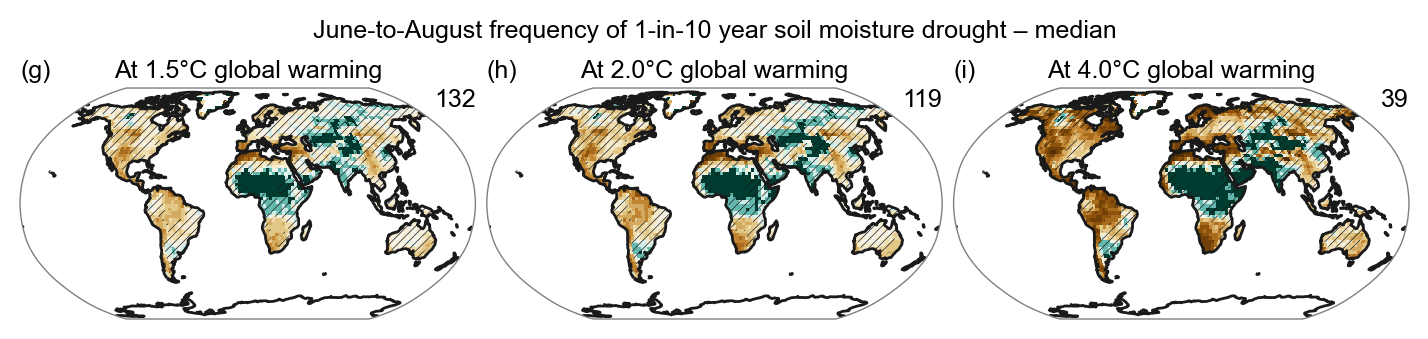

In [33]:
season = "JJA"

levels = np.linspace(np.log10(0.125), np.log10(8), num=19)

cbar = plot.at_warming_level_one(
    seas_drought_freq_wrt_clim_for_plot[season],
    "Change (times as frequent)",
    "June-to-August frequency of 1-in-10 year soil moisture drought",
    levels=levels,
    average="median",
    mask_ocean=True,
    cmap="BrBG_r",
    hatch_simple=0.8,
    add_legend=False,
    colorbar=False,
    #     extend="min",
)

# format_cbar(cbar)

f = plt.gcf()
axes = f.axes[:3]

axes[0].set_title("(g)", fontsize=9, pad=4, loc="left")
axes[1].set_title("(h)", fontsize=9, pad=4, loc="left")
axes[2].set_title("(i)", fontsize=9, pad=4, loc="left")

fN = conf.cmip6.figure_filename(
    f"sm_drought_frequency_{season}_wrt_1850_1900", FIGURE_FOLDER_11_19
)
plt.savefig(fN + ".pdf", dpi=300)
plt.savefig(fN + ".png", dpi=300, transparent=False, facecolor="w")

# data tables
# =================================================================


fN = conf.cmip6.figure_filename(
    f"sm_drought_frequency_{season}_wrt_1850_1900", FIGURE_FOLDER_11_19, "data_tables"
)

dta_ = seas_drought_freq_wrt_clim_for_plot[season]
override = dict(postprocess="sm_regrid")
data_tables.save_simulation_info_raw(
    fN + "_1.5_md_raw", dta_[0], panel="g", override=override
)
data_tables.save_simulation_info_raw(
    fN + "_2.0_md_raw", dta_[1], panel="h", override=override
)
data_tables.save_simulation_info_raw(
    fN + "_4.0_md_raw", dta_[2], panel="i", override=override
)


# save figure data
# =================================================================
# NOTE: use original data not in log10
# the order of operations (log10 and median leads to a
# difference in a few grid points)

dta_ = seas_drought_freq_wrt_clim

varn = "SM_drought_index"
figure = "Figure 11.19"
sfd = save_figuredata.SaveFiguredata(
    figure=figure,
    units="- (times as frequent)",
    varn=varn,
)

figure = figure.replace(" ", "_")
panels = ["g", "h", "i"]
for i, warming_level in enumerate([1.5, 2.0, 4.0]):

    panel = panels[i]
    fN = conf.cmip6.figure_filename(
        f"{figure}{panel}_{season}_cmip6_{varn}_change_at_{warming_level:0.1f}C.nc",
        FIGURE_FOLDER_11_19,
        "figure_data",
        add_prefix=False,
    )

    da = dta_[str(warming_level)].sel(season=season)

    da.attrs["long_name"] = "Total Soil Moisture Drought"
    da.attrs["comment"] = "anomaly wrt 1850-1900; best shown on a log-scale"

    ds = sfd.map_panel(
        da=da,
        average="median",
        panel=panel,
        warming_level=warming_level,
        hatch_simple=0.8,
    )

    ds.attrs["season"] = season

    ds.to_netcdf(fN)

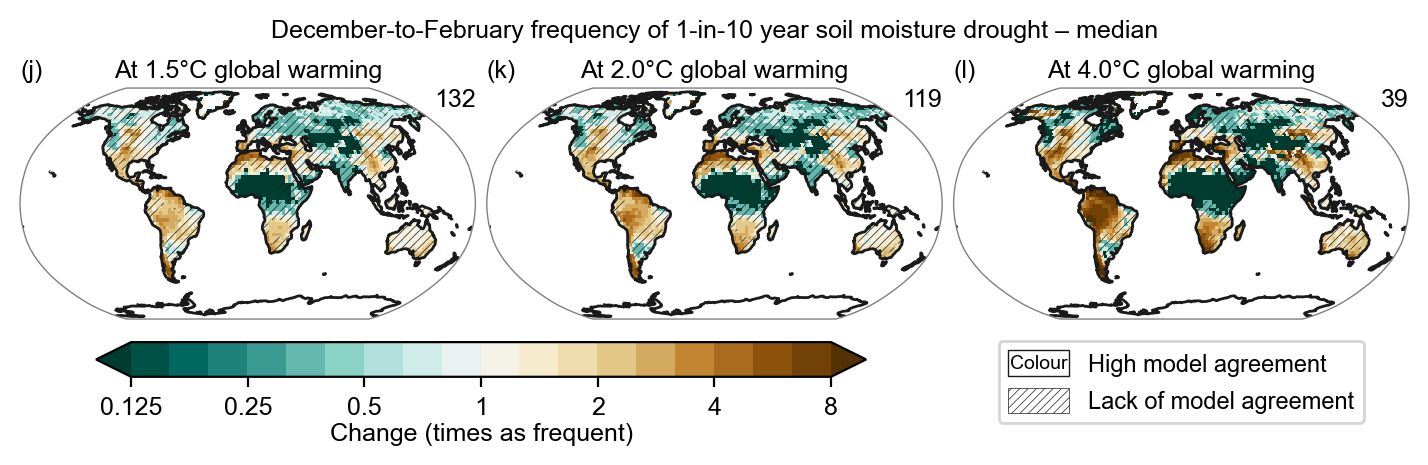

In [34]:
season = "DJF"

levels = np.arange(-1, 1.1, 0.1)

levels = np.linspace(np.log10(0.125), np.log10(8), num=19)


cbar = plot.at_warming_level_one(
    seas_drought_freq_wrt_clim_for_plot[season],
    "Change (times as frequent)",
    "December-to-February frequency of 1-in-10 year soil moisture drought",
    levels=levels,
    average="median",
    mask_ocean=True,
    cmap="BrBG_r",
    hatch_simple=0.8,
    add_legend=True,
    #     extend="min",
)

format_cbar(cbar)


f = plt.gcf()
axes = f.axes[:3]

axes[0].set_title("(j)", fontsize=9, pad=4, loc="left")
axes[1].set_title("(k)", fontsize=9, pad=4, loc="left")
axes[2].set_title("(l)", fontsize=9, pad=4, loc="left")

fN = conf.cmip6.figure_filename(
    f"sm_drought_frequency_{season}_wrt_1850_1900", FIGURE_FOLDER_11_19
)
plt.savefig(fN + ".pdf", dpi=300)
plt.savefig(fN + ".png", dpi=300, transparent=False, facecolor="w")


# data tables
# =================================================================

fN = conf.cmip6.figure_filename(
    f"sm_drought_frequency_{season}_wrt_1850_1900", FIGURE_FOLDER_11_19, "data_tables"
)

dta_ = seas_drought_freq_wrt_clim_for_plot[season]
override = dict(postprocess="sm_regrid")
data_tables.save_simulation_info_raw(
    fN + "_1.5_md_raw", dta_[0], panel="j", override=override
)
data_tables.save_simulation_info_raw(
    fN + "_2.0_md_raw", dta_[1], panel="k", override=override
)
data_tables.save_simulation_info_raw(
    fN + "_4.0_md_raw", dta_[2], panel="l", override=override
)


# save figure data
# =================================================================
# NOTE: use original data not in log10
# the order of operations (log10 and median leads to a
# difference in a few grid points)

dta_ = seas_drought_freq_wrt_clim

varn = "SM_drought_index"
figure = "Figure 11.19"
sfd = save_figuredata.SaveFiguredata(
    figure=figure,
    units="- (times as frequent)",
    varn=varn,
)

figure = figure.replace(" ", "_")
panels = ["j", "k", "l"]
for i, warming_level in enumerate([1.5, 2.0, 4.0]):

    panel = panels[i]
    fN = conf.cmip6.figure_filename(
        f"{figure}{panel}_cmip6_{season}_{varn}_change_at_{warming_level:0.1f}C.nc",
        FIGURE_FOLDER_11_19,
        "figure_data",
        add_prefix=False,
    )
    
    da = dta_[str(warming_level)].sel(season=season)

    
    da.attrs["long_name"] = "Total Soil Moisture Drought"
    da.attrs["comment"] = "anomaly wrt 1850-1900; best shown on a log-scale"

    ds = sfd.map_panel(
        da=da,
        average="median",
        panel=panel,
        warming_level=warming_level,
        hatch_simple=0.8,
    )

    ds.attrs["season"] = season

    ds.to_netcdf(fN)

## Intensity

well not really intensity but threshold

In [35]:
def calculate_drought_intensity(data, n_years):
    """10-year drought threshold"""

    warming_levels = [0.84, 1.0, 1.5, 2.0, 3.0, 4.0]

    # get the data for 1850-1900 (raw)
    data_1850_1900 = computation.time_average(
        data, 1850, 1900, reduce=None, as_datalist=True
    )

    # get the data for warning levels (raw)
    data_selected = computation.at_warming_levels_dict(
        c6_tas,
        data,
        warming_levels=warming_levels,
        n_years=n_years,
        reduce=None,
        as_datalist=True,
    )

    data_selected["clim"] = data_1850_1900

    drought_intensity = dict()
    for key, dta in data_selected.items():

        # compute the intensity (10th quantile)
        t = computation.process_datalist(quantile_via_probplot, dta, q=0.1, dim="year")
        t = computation.concat_xarray_with_metadata(t)

        drought_intensity[key] = t

    return drought_intensity

#### Annual mean intensity

In [36]:
drought_intensity = calculate_drought_intensity(c6_mrso, n_years=30)

In [37]:
out = compute_anomaly_and_mmm(drought_intensity, "clim", "absolute")
drought_intensity_wrt_clim, drought_intensity_wrt_clim_mmm = out

In [38]:
out = compute_anomaly_and_mmm(drought_intensity, "0.84", "absolute")
drought_intensity_wrt_084, drought_intensity_wrt_084_mmm = out

#### Seasonal mean intensity

In [39]:
seas_drought_intensity = calculate_drought_intensity(c6_mrso_seas, n_years=30)

In [40]:
out = compute_anomaly_and_mmm(seas_drought_intensity, "clim", "absolute")
seas_drought_intensity_wrt_clim, seas_drought_intensity_wrt_clim_mmm = out

In [41]:
out = compute_anomaly_and_mmm(seas_drought_intensity, "0.84", "absolute")
seas_drought_intensity_wrt_084, seas_drought_intensity_wrt_084_mmm = out

## Intensity: warming level plot

- wrt climatology

In [42]:
# read data for the warming level plot

c6_drought_intensity_at_w = [
    drought_intensity_wrt_clim[key] for key in ["1.5", "2.0", "4.0"]
]

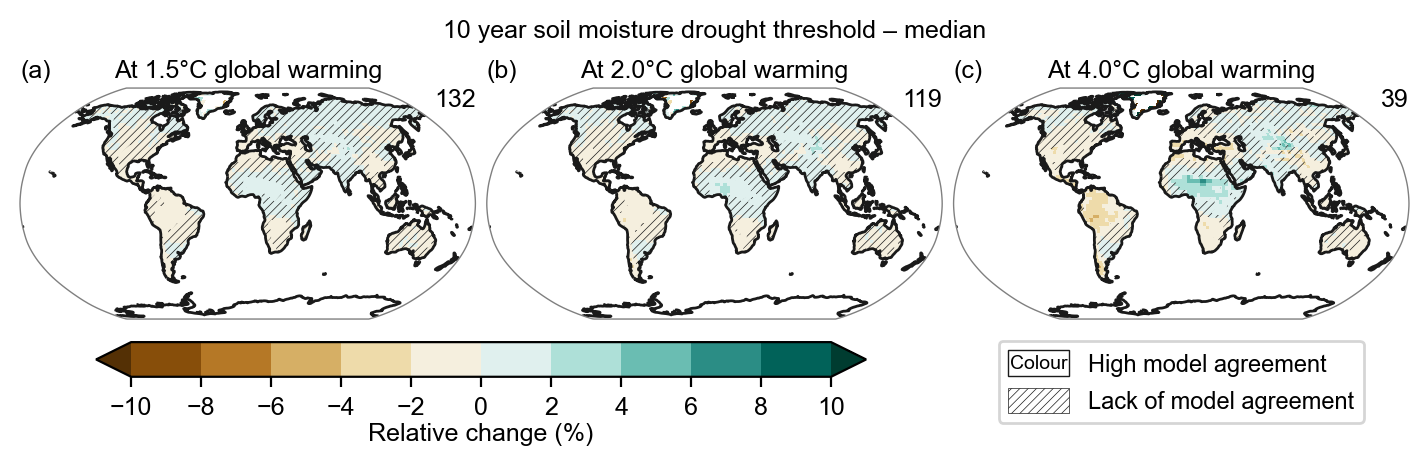

In [43]:
levels = np.arange(-10, 11, 2)

cbar = plot.at_warming_level_one(
    c6_drought_intensity_at_w,
    "Relative change (\sigma)",
    "10 year soil moisture drought threshold",
    levels=levels,
    average="median",
    mask_ocean=True,
    robust=True,
    cmap="BrBG",
    hatch_simple=0.8,
    add_legend=True,
)
cbar.set_ticks(levels)

## Write regional data to excel

In [44]:
def _to_regional_quantiles(da, mask_3D, q):

    # quantiles
    reg_quant = da.where(mask_3D).quantile(dim=["lon", "lat"], q=q).T

    return reg_quant


def to_regional_quantiles(dict_of_da, mask_3D, q=[0.5, 0.17, 0.83, 0.05, 0.95]):
    return {
        k: _to_regional_quantiles(dict_of_da[k], mask_3D, q=q)
        for k in dict_of_da.keys()
    }

In [45]:
import pandas as pd

In [46]:
def prepare_for_excel(regional_quantiles, temp, name, season=None):
    """transform data to required format"""

    da = regional_quantiles[temp]
    
    if season is not None:
        da = da.sel(season=season)

    df = da.to_pandas()

    # rename columns
    columns = df.columns
    columns = [f"{int(c * 100)}th" for c in columns]
    df.columns = columns

    # add names as column
    df["names"] = da.names.values
    
    columns = df.columns.tolist()
    columns = columns[-1:] + columns[:-1]
    df = df[columns]

    df.index += 1
    # copy column for non-existing 50-year event
    df_duplicated = df.iloc[:, 1:]
    df_duplicated.loc[:, :] = np.nan
    
    df_duplicated

    df = pd.concat([df, df_duplicated], axis=1)

    # create hierarchical column titles
    event = "dry event"

    columns1 = [""] + [name] * 10
    columns2 = [""] + [f"10-year {event}"] * 5 + [f"50-year {event}"] * 5
    columns3 = df.columns

    mi = pd.MultiIndex.from_arrays([columns1, columns2, columns3])
    df.columns = mi

    sheet_name = f"{temp}deg C"

    return df, sheet_name

In [47]:
def write_excel(fN, freq, intensity, season=None):

    with pd.ExcelWriter(fN) as writer:

        for wl in ["1.0", "1.5", "2.0", "3.0", "4.0"]:
            df_freq, sheet_name = prepare_for_excel(
                freq, wl, "Frequency change (unitless)", season=season
            )

            df_intensity, sheet_name = prepare_for_excel(
                intensity, wl, "Intensity change (σ)", season=season
            )
            
            df_intensity = df_intensity.drop(columns=("", "", "names"))
            df = pd.concat([df_freq, df_intensity], axis=1)

            df.to_excel(writer, sheet_name=sheet_name, na_rep="-", float_format="%0.2f")

In [48]:
root = "../data/cmip6/sm_drought/"

#### Write data tables

> Note: drought_freq and drought_intensity has the same models

In [49]:
def write_data_table(fN, data, clim):

    fN = fN.replace(".xlsx", "")
    for wl in [clim, "1.0", "1.5", "2.0", "3.0", "4.0"]:
        fN_ = fN + f"_md_{wl}_raw"
        da = data[wl]
        data_tables.save_simulation_info_raw(
            fN_, da, iav=None, panel=wl, add_historical=True, add_tas=True
        )

#### Write drought freq & threshold to excel

*annual mean wrt 1850-1900*

In [50]:
drought_freq_wrt_clim_mmm_reg = to_regional_quantiles(drought_freq_wrt_clim_mmm, mask_3D)
drought_intensity_wrt_clim_mmm_reg = to_regional_quantiles(drought_intensity_wrt_clim_mmm, mask_3D)

fN = root + "ChangesSMDrought_annual_baseline1850_1900.xlsx"
write_excel(fN, drought_freq_wrt_clim_mmm_reg, drought_intensity_wrt_clim_mmm_reg)

# write_data_table(fN, drought_freq_wrt_clim)

/home/mathause/.conda/envs/ipcc_ar6/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/mathause/.conda/envs/ipcc_ar6/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/mathause/.conda/envs/ipcc_ar6/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


*annual mean wrt 0.84*

In [51]:
# drought_freq_wrt_084_mmm_reg = to_regional_quantiles(drought_freq_wrt_084_mmm, mask_3D)
# drought_intensity_wrt_084_mmm_reg = to_regional_quantiles(drought_intensity_wrt_084_mmm, mask_3D)

# fN = root + "ChangesSMDrought_annual_baseline0.84.xlsx"
# write_excel(fN, drought_freq_wrt_084_mmm_reg, drought_intensity_wrt_084_mmm_reg)

# write_data_table(fN, drought_freq_wrt_clim)

*seasonal mean wrt 1850-1900*

In [52]:
seas_drought_freq_wrt_clim_mmm_reg = to_regional_quantiles(
    seas_drought_freq_wrt_clim_mmm,
    mask_3D,
)
seas_drought_intensity_wrt_clim_mmm_reg = to_regional_quantiles(
    seas_drought_intensity_wrt_clim_mmm,
    mask_3D,
)


for season in ["DJF", "JJA"]:

    fN = root + f"ChangesSMDrought_{season}_baseline1850_1900.xlsx"
    write_excel(
        fN,
        seas_drought_freq_wrt_clim_mmm_reg,
        seas_drought_intensity_wrt_clim_mmm_reg,
        season=season,
    )

### write data tables

Note:
- freq and intensity need the same data table (however, intensity are not used here)
- we need to use `drought_freq_hist_30` so we have all necessary data (models and the climatology)

In [53]:
# season = "seasonal"
# fN = root + f"ChangesSMDrought_{season}_baseline1850_1900"
# write_data_table(fN, drought_freq_hist_30, clim="clim")

**seasonal mean wrt 0.84**

In [54]:
# seas_drought_freq_wrt_084_mmm_reg = to_regional_quantiles(seas_drought_freq_wrt_084_mmm, mask_3D)
# seas_drought_intensity_wrt_084_mmm_reg = to_regional_quantiles(
#     seas_drought_intensity_wrt_084_mmm, mask_3D,
# )


# for season in ["DJF", "JJA":

#     fN = root + f"ChangesSMDrought_{season}_baseline0.84.xlsx"
#     write_excel(
#         fN,
#         seas_drought_freq_wrt_084_mmm_reg,
#         seas_drought_intensity_wrt_084_mmm_reg,
#         season=season,
#     )

## Drought prone regions

In [55]:
# OLD DEFINITON
# high confidence agricultural/ecological drought at 4°C


# drought_prone = [
#     "CNA",
#     "NCA",
#     "SCA",
#     "NSA",
#     "SAM",
#     "SWS",
#     "SSA",
#     "MED",
#     "WSAF",
#     "ESAF",
#     "MDG",
#     "EAU",
#     "SAU",
# ]


# NEW DEFINITON
# medium confidence agricultural/ecological drought at 2°C
# adds 3 regions WNA, NES, and WCE

drought_prone = [
    "CNA",
    "EAU",
    "ESAF",
    "MDG",
    "MED",
    "NCA",
    "NES",
    "NSA",
    "SAM",
    "SAU",
    "SCA",
    "SSA",
    "SWS",
    "WCE",
    "WNA",
    "WSAF",
]

# get other regions (i.e. not drought prone)
not_drought_prone = list(set(ar6_land.abbrevs) - set(drought_prone))

ar6_land_not_dpr = ar6_land[not_drought_prone]
ar6_land_dpr = ar6_land[drought_prone]

In [56]:
print(ar6_land_dpr._display(max_rows=None))

<regionmask.Regions>
Name:     AR6 reference regions (land only)
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)

Regions:
 3  WNA        W.North-America
 4  CNA        C.North-America
 6  NCA      N.Central-America
 7  SCA      S.Central-America
10  NSA        N.South-America
11  NES      N.E.South-America
12  SAM South-American-Monsoon
13  SWS      S.W.South-America
15  SSA        S.South-America
17  WCE    West&Central-Europe
19  MED          Mediterranean
25 WSAF      W.Southern-Africa
26 ESAF      E.Southern-Africa
27  MDG             Madagascar
41  EAU            E.Australia
42  SAU            S.Australia

[16 regions]


In [57]:
print(ar6_land_not_dpr._display(max_rows=None))

<regionmask.Regions>
Name:     AR6 reference regions (land only)
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)

Regions:
 0  GIC Greenland/Iceland
 1  NWN N.W.North-America
 2  NEN N.E.North-America
 5  ENA   E.North-America
 8  CAR         Caribbean
 9  NWS N.W.South-America
14  SES S.E.South-America
16  NEU          N.Europe
18  EEU          E.Europe
20  SAH            Sahara
21  WAF    Western-Africa
22  CAF    Central-Africa
23 NEAF  N.Eastern-Africa
24 SEAF  S.Eastern-Africa
28  RAR    Russian-Arctic
29  WSB         W.Siberia
30  ESB         E.Siberia
31  RFE  Russian-Far-East
32  WCA          W.C.Asia
33  ECA          E.C.Asia
34  TIB   Tibetan-Plateau
35  EAS            E.Asia
36  ARP Arabian-Peninsula
37  SAS            S.Asia
38  SEA          S.E.Asia
39  NAU       N.Australia
40  CAU       C.Australia
43   NZ       New-Zealand
44  EAN      E.Antarctica
45  WAN      W.Antarctica

[30 regions]


In [58]:
def plot_regions(reg, title, ax, add_label=False):

    
    text_kws = None
    if add_label:
        text_kws = dict(color="#67000d", fontsize=6, bbox=dict(pad=0.2, color="w"))

    ax = reg.plot(
        text_kws=text_kws,
        label="abbrev",
        line_kws=dict(linewidth=0.5, color="#67000d"),
        ax=ax,
        add_label=add_label,
    )

    ax.set_title(title, fontsize=9)

    ax.set_global()



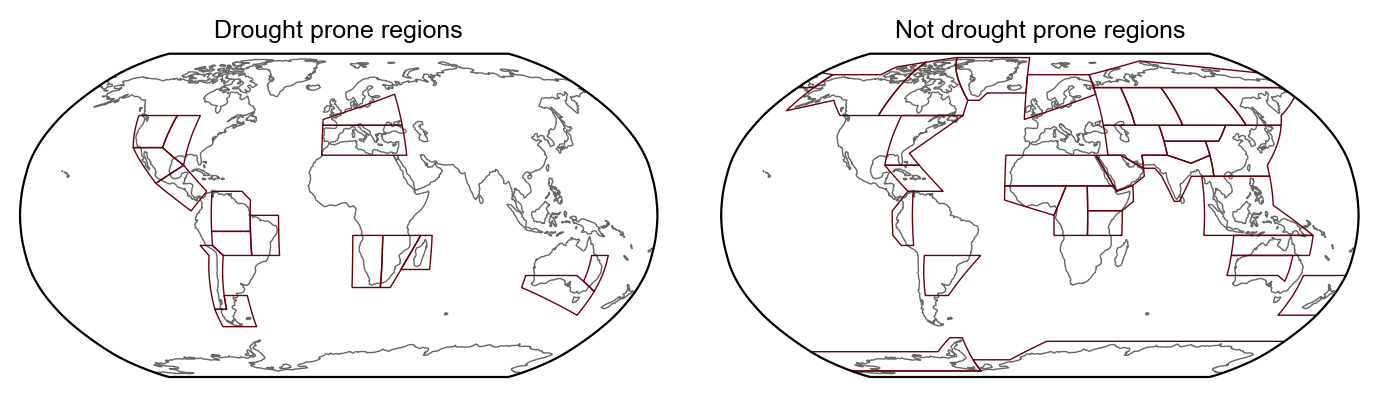

In [59]:
f, axs = plot.map_subplots(1, 2)

plot_regions(ar6_land_dpr, "Drought prone regions", axs[0])
plot_regions(ar6_land_not_dpr, "Not drought prone regions", axs[1])

f.subplots_adjust(left=0, right=1, wspace=0.1)
mpu.set_map_layout(axs)

### Create a 3D mask of the combined regions

In [60]:
def create_combined_3D_mask(ds, reg, name, abbrev):
    """create a single 3D mask from regionmask.Regions
    
    ds : xr.Dataset
        Dataset to be used for the grid.
    reg : regionmask.Regions
        Regions to create the single mask from
    name : str
        Name of the combied region
    abbrev : str
        Abbreviation of the combined region    
    """

    mask_3D_ = reg.mask_3D(ds)

    mask_3D_ = mask_3D_.any("region").expand_dims("region")

    mask_3D_ = mask_3D_.assign_coords(
        region=[0], names=("region", [name]), abbrevs=("region", [abbrev])
    )

    return mask_3D_

In [61]:
# a random ds - they all have the same grid
ds = c6_mrso_no_anom[0][0]

mask_3D_dpr = create_combined_3D_mask(ds, ar6_land_dpr, "Drought prone regions", "dpr")

mask_3D_not_dpr = create_combined_3D_mask(
    ds, ar6_land_not_dpr, "Not drought prone regions", "ndpr"
)

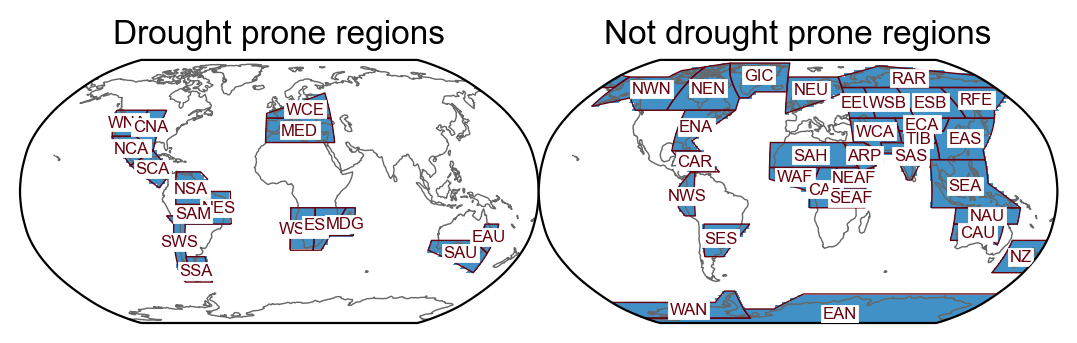

In [62]:
# ====

text_kws = dict(color="#67000d", fontsize=5, bbox=dict(pad=0.2, color="w"))

f, axes = plot.map_subplots(1, 2)

_mask_3D_ = [mask_3D_dpr, mask_3D_not_dpr]

for i, reg in enumerate([ar6_land_dpr, ar6_land_not_dpr]):

    ax = axes[i]

    plot_regions(reg, "", ax, add_label=True)

    _mask_3D_[i].where(_mask_3D_[i] == 1).plot(
        ax=ax, cmap="Blues", vmin=0, vmax=1.6, add_colorbar=False, transform=ccrs.PlateCarree()
    )
    
f.subplots_adjust(wspace=0)

axes[0].set_title("Drought prone regions")
axes[1].set_title("Not drought prone regions")

mpu.set_map_layout(axes)

### Calculate freq and intensity change over the drought prone regions

In [63]:
drought_freq_wrt_clim_reg_dpr = to_regional_quantiles(
    drought_freq_wrt_clim, mask_3D_dpr, q=0.5
)
drought_intensity_wrt_clim_reg_dpr = to_regional_quantiles(
    drought_intensity_wrt_clim, mask_3D_dpr, q=0.5
)


seas_drought_freq_wrt_clim_reg_dpr = to_regional_quantiles(
    seas_drought_freq_wrt_clim, mask_3D_dpr, q=0.5
)
seas_drought_intensity_wrt_clim_reg_dpr = to_regional_quantiles(
    seas_drought_intensity_wrt_clim, mask_3D_dpr, q=0.5
)


# ----

drought_freq_wrt_clim_reg_not_dpr = to_regional_quantiles(
    drought_freq_wrt_clim, mask_3D_not_dpr, q=0.5
)
drought_intensity_wrt_clim_reg_not_dpr = to_regional_quantiles(
    drought_intensity_wrt_clim, mask_3D_not_dpr, q=0.5
)

### calculate inter-model spread

In [64]:
def mod_ens_q(data):

    q = [0.5, 0.17, 0.83, 0.05, 0.95]
    keys = data.keys()
    data = {key: data[key].quantile(dim="mod_ens", q=q) for key in keys}

    data = xr.concat(data.values(), dim="warming_level")
    data = data.assign_coords(warming_level=list(keys))

    return data.squeeze()

#### write to csv

In [65]:
d_freq = mod_ens_q(drought_freq_wrt_clim_reg_dpr)
d_freq = d_freq.to_pandas()


dpr = ", ".join(drought_prone)

header = [
    "# Soil moisture drought (based on annual mean SM)\n",
    "# Frequency change in drought prone super-region\n",
    "# 1-in-10 year event\n",
    "# baseline 1850-1900\n",
    f"# combined AR6 regions: {dpr}\n",
    "# units: (-) ['times as frequent as in 1850-1900']\n",
    "# given at different warming levels (30 year each)\n",
    "# and for different quantile (spatially!) for the multi model median\n",
    "# Calculation:\n",
    "# - Normalize annual mean SM ((SM - μ) / σ, where μ & σ is the mean & standard deviation over 1850-1900)\n",
    "# - determine 10th quantile of annual mean SM (1850-1900) (= drought threshold)\n",
    "# - a drought event occurs if annual mean SM smaller threshold\n",
    "# - calc mean freq for 1850-1900 and each warming level (wl)\n",
    "# - calc fractional change: freq at wl / freq at 1850-1900 (= times as frequent)\n",
    "# - calculate spatial median\n",
    "# - calculate the multi model quantiles\n",
]


fN = root + "drought_prone_regions_annual_wrt_1850_1900_frequency.csv"

with open(fN, "w") as fid:

    fid.writelines(header)
    d_freq.drop(index=["0.84"]).to_csv(fid, float_format="%0.2f")

In [66]:
mkdir ../data/cmip6/sm_drought/

mkdir: cannot create directory ‘../data/cmip6/sm_drought/’: File exists


In [67]:
d_freq_not_dpr = mod_ens_q(drought_freq_wrt_clim_reg_not_dpr)
d_freq_not_dpr = d_freq_not_dpr.to_pandas()

In [68]:
! cat ../data/cmip6/sm_drought/drought_prone_regions_annual_wrt_1850_1900_frequency.csv

# Soil moisture drought (based on annual mean SM)
# Frequency change in drought prone super-region
# 1-in-10 year event
# baseline 1850-1900
# combined AR6 regions: CNA, EAU, ESAF, MDG, MED, NCA, NES, NSA, SAM, SAU, SCA, SSA, SWS, WCE, WNA, WSAF
# units: (-) ['times as frequent as in 1850-1900']
# given at different warming levels (30 year each)
# and for different quantile (spatially!) for the multi model median
# Calculation:
# - Normalize annual mean SM ((SM - μ) / σ, where μ & σ is the mean & standard deviation over 1850-1900)
# - determine 10th quantile of annual mean SM (1850-1900) (= drought threshold)
# - a drought event occurs if annual mean SM smaller threshold
# - calc mean freq for 1850-1900 and each warming level (wl)
# - calc fractional change: freq at wl / freq at 1850-1900 (= times as frequent)
# - calculate spatial median
# - calculate the multi model quantiles
warming_level,0.50,0.17,0.83,0.05,0.95
1.0,1.70,1.02,2.38,0.68,4.08
1.5,2.04,1.11,3.40,1.02,5.10
2.0,2.38,1.3

In [69]:
d_intensity = mod_ens_q(drought_intensity_wrt_clim_reg_dpr)
d_intensity = d_intensity.to_pandas()

dpr = ", ".join(drought_prone)

header = [
    "# Soil moisture drought (based on annual mean SM)\n",
    "# Intensity (threshold) change in drought prone super-region\n",
    "# 1-in-10 year event\n",
    "# baseline 1850-1900\n",
    f"# combined AR6 regions: {dpr}\n",
    "# units: (σ) ['change w.r.t. 1850-1900']\n",
    "# given at different warming levels (30 year each)\n",
    "# and for different quantile (spatially!) for the multi model median\n",
    "# Calculation:\n",
    "# - Normalize annual mean SM ((SM - μ) / σ, where μ & σ is the mean & standard deviation over 1850-1900)\n",
    "# - determine 10th quantile of annual mean SM (at 1850-1900 and all warming levels)\n",
    "# - calc change: (intensity at wl - intensity at 1850-1900)\n",
    "# - calculate the multi model median\n",
    "# - calculate spatial quantiles\n",
]


fN = root + "drought_prone_regions_annual_wrt_1850_1900_intensity.csv"

with open(fN, "w") as fid:

    fid.writelines(header)
    d_intensity.drop(index=["0.84"]).to_csv(fid, float_format="%0.2f")

In [70]:
d_intensity_not_dpr = mod_ens_q(drought_intensity_wrt_clim_reg_not_dpr)
d_intensity_not_dpr = d_intensity_not_dpr.to_pandas()

In [71]:
# not no to_pandas -> they the season needs to be selected first
seas_d_freq = mod_ens_q(seas_drought_freq_wrt_clim_reg_dpr)
seas_d_intensity = mod_ens_q(seas_drought_intensity_wrt_clim_reg_dpr)

In [72]:
! cat ../data/cmip6/sm_drought/drought_prone_regions_annual_wrt_1850_1900_intensity.csv

# Soil moisture drought (based on annual mean SM)
# Intensity (threshold) change in drought prone super-region
# 1-in-10 year event
# baseline 1850-1900
# combined AR6 regions: CNA, EAU, ESAF, MDG, MED, NCA, NES, NSA, SAM, SAU, SCA, SSA, SWS, WCE, WNA, WSAF
# units: (σ) ['change w.r.t. 1850-1900']
# given at different warming levels (30 year each)
# and for different quantile (spatially!) for the multi model median
# Calculation:
# - Normalize annual mean SM ((SM - μ) / σ, where μ & σ is the mean & standard deviation over 1850-1900)
# - determine 10th quantile of annual mean SM (at 1850-1900 and all warming levels)
# - calc change: (intensity at wl - intensity at 1850-1900)
# - calculate the multi model median
# - calculate spatial quantiles
warming_level,0.50,0.17,0.83,0.05,0.95
1.0,-0.32,-0.53,0.01,-1.07,0.19
1.5,-0.46,-0.75,-0.10,-1.40,0.01
2.0,-0.57,-0.93,-0.18,-1.49,-0.07
3.0,-0.78,-1.26,-0.43,-2.23,-0.18
4.0,-0.99,-1.64,-0.49,-2.03,-0.27


#### Write data table

- freq and intensity need the same data table (however, intensity are not used here)
- we need to use `drought_freq_hist_30` so we have all necessary data (models and the climatology)

In [73]:
fN = root + "drought_prone_regions_annual_wrt_1850_1900"
write_data_table(fN, drought_freq_hist_30, clim="clim")

## Boxplot

In [74]:
def get_boxtats(data):

    data = data.loc["1.0":"4.0"]

    out = list()
    for key, row in data.iterrows():

        bxpstats = dict(
            med=row[0.5],
            q1=row[0.17],
            q3=row[0.83],
            whislo=row[0.05],
            whishi=row[0.95],
            fliers=[],
            label=key,
        )
        out.append(bxpstats)

    return out

__empty space is for map__

In [75]:
def add_ens(ax, data):

    trans = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for i, t in enumerate(["1.0", "1.5", "2.0", "3.0", "4.0"]):

        n_mod = len(data[t].mod_ens)
        ax.text(
            i + 1,
            0.99,
            f"({n_mod})",
            fontsize=7,
            ha="center",
            va="top",
            transform=trans,
        )

In [76]:
FIGURE_FOLDER_11_18 = "Figure_11.18_SM_drought_dpr"

plot.create_figure_folders(FIGURE_FOLDER_11_18, conf.cmip6)

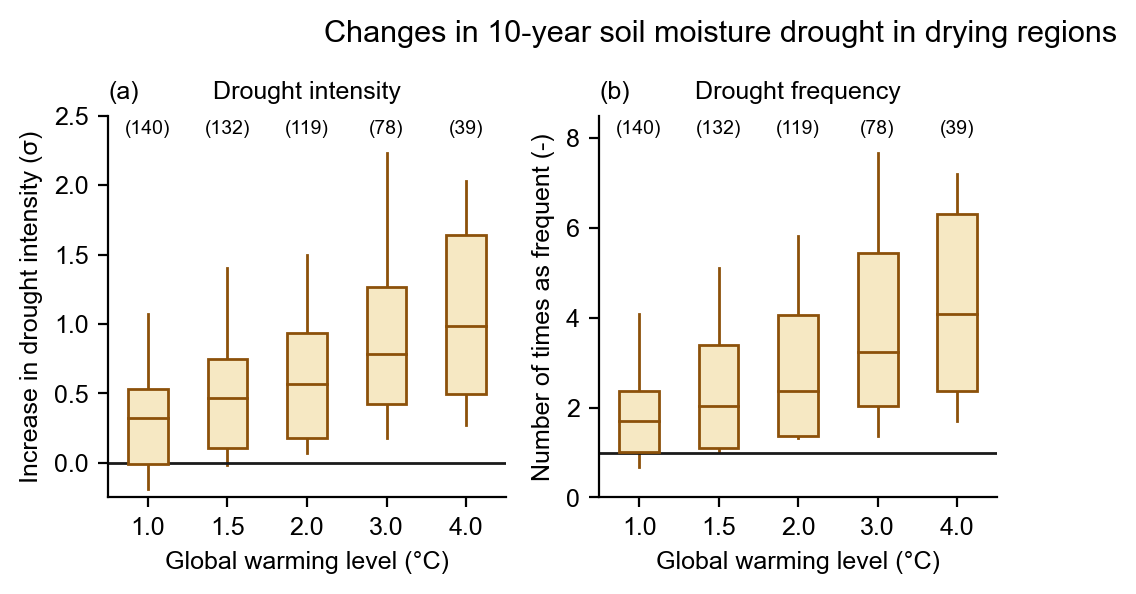

In [77]:
def boxplot_changes_in_drought(d_intensity_, d_freq_, title):

    ec = "#8c510a"

    box_opt = dict(
        showcaps=False,
        boxprops=dict(fc="#f6e8c3", ec=ec),
        medianprops=dict(color=ec),
        whiskerprops=dict(color=ec),
        patch_artist=True,
    )

    # ===

    f, axes = plt.subplots(1, 3, constrained_layout=True)

    f.set_size_inches(18 / 2.54, 7.25 / 2.54)

    ax = axes[0]

    ax.bxp(get_boxtats(-d_intensity_), **box_opt)

    ax.set_ylabel("Increase in drought intensity (σ)", fontsize=9)
    ax.set_title("Drought intensity", fontsize=9)
    ax.set_title("(a)", fontsize=9, loc="left")
    ax.axhline(0, lw=1, color="0.1")
    ax.set_ylim(-0.1, None)

    # NOTE: I can use this for both (same datasource)
    add_ens(ax, drought_intensity_wrt_clim_reg_dpr)

    # =====

    ax = axes[1]

    ax.bxp(get_boxtats(d_freq_), **box_opt)

    ax.axhline(1, lw=1, color="0.1")

    ax.set_title("Drought frequency", fontsize=9)
    ax.set_title("(b)", fontsize=9, loc="left")

    ax.set_ylabel("Number of times as frequent (-)", fontsize=9)
    ax.set_ylim(0, None)

    # NOTE: I can use this for both (same datasource)
    add_ens(ax, drought_freq_wrt_clim_reg_dpr)

    # =====

    sns.despine(f)

    for ax in axes:
        ax.tick_params(axis="both", which="major", labelsize=9)
        ax.set_xlabel("Global warming level (°C)", fontsize=9)

    axes[2].set_visible(False)
    f.suptitle(title, fontsize=11)  # , y=0.98)

    axes[0].set_ylim(-0.25, 2.5)
    axes[1].set_ylim(None, 8.5)

    return axes


boxplot_changes_in_drought(
    d_intensity, d_freq, "Changes in 10-year soil moisture drought in drying regions"
)


fN = conf.cmip6.figure_filename(
    "Figure_11.18ab_SMDroughtIndex_dpr_intensity_frequency",
    FIGURE_FOLDER_11_18,
    add_prefix=False,
)
plt.savefig(fN + ".pdf", dpi=300)
plt.savefig(fN + ".png", dpi=300, transparent=False, facecolor="w")

# can use one for the data tables
fN = conf.cmip6.figure_filename(
    "Figure_11.18ab_SMDroughtIndex_dpr_intensity_frequency",
    FIGURE_FOLDER_11_18,
    "data_tables",
    add_prefix=False,
)

dta_ = drought_intensity_wrt_clim_reg_dpr["1.0"]
data_tables.save_simulation_info_raw(fN + "_all_md_raw", dta_[0], panel="a, b")

In [78]:
season

'JJA'

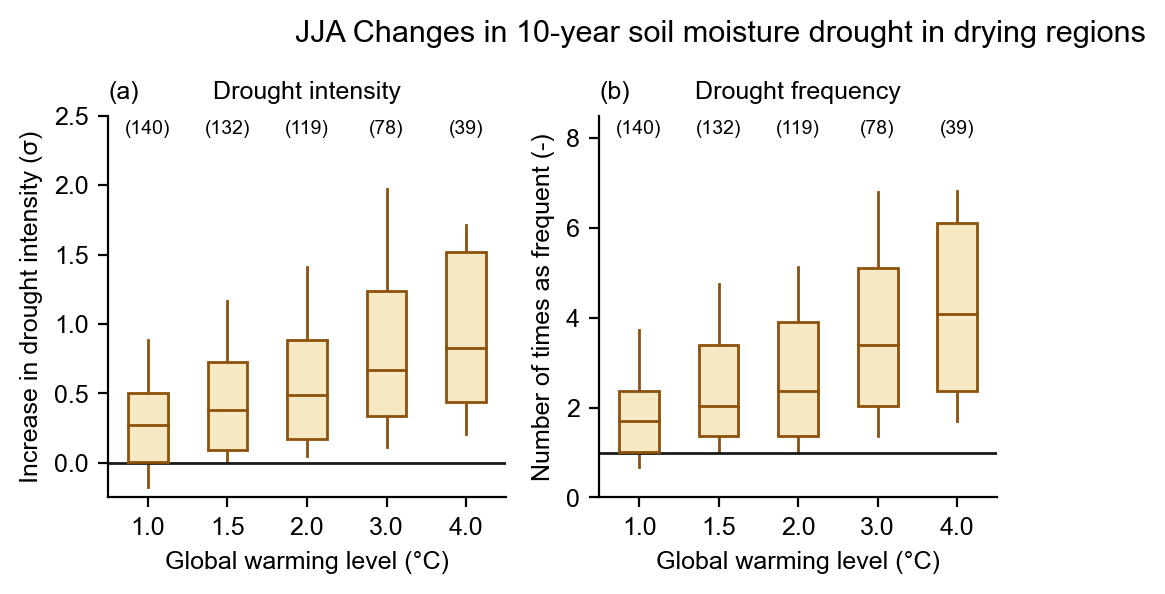

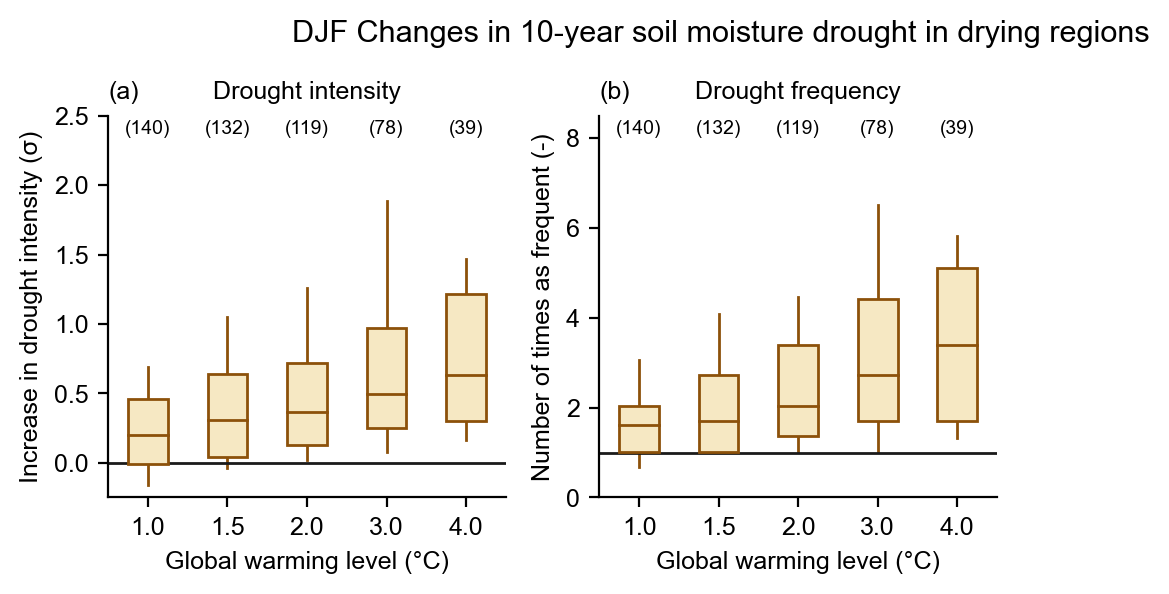

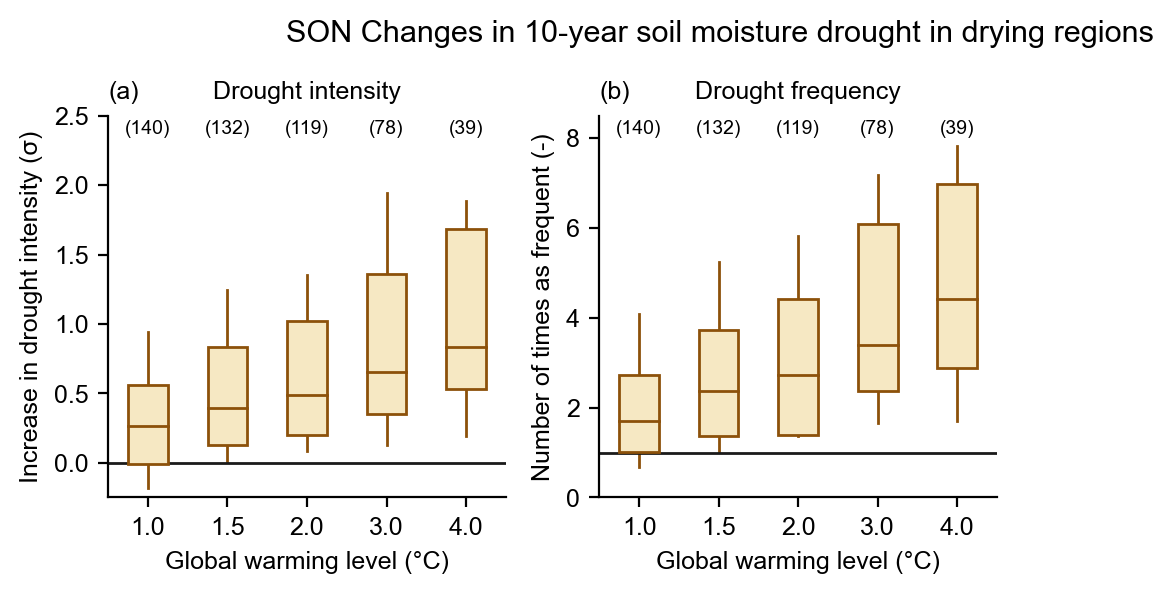

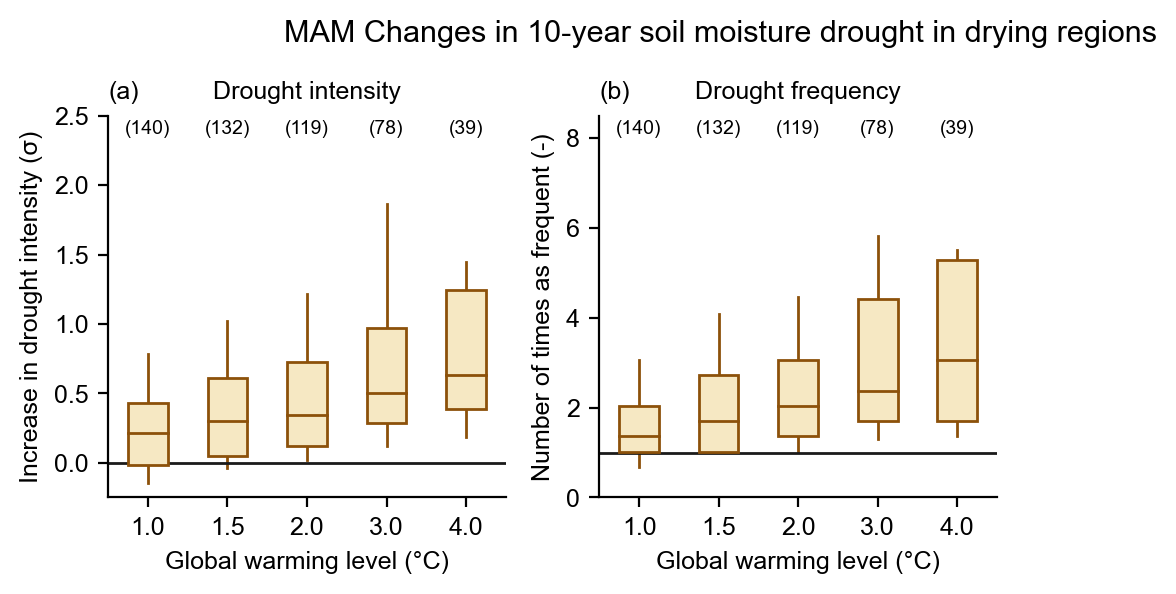

In [79]:
# seas_d_freq = seas_d_freq.to_pandas()

for season in ["JJA", "DJF", "SON", "MAM"]:

    boxplot_changes_in_drought(
        seas_d_intensity.sel(season=season).to_pandas(),
        seas_d_freq.sel(season=season).to_pandas(),
        f"{season} Changes in 10-year soil moisture drought in drying regions",
    )

    fN = conf.cmip6.figure_filename(
        f"Figure_11.18ab_SMDroughtIndex_dpr_intensity_frequency_{season}",
        FIGURE_FOLDER_11_18,
        add_prefix=False,
    )
    plt.savefig(fN + ".pdf", dpi=300)
    plt.savefig(fN + ".png", dpi=300, transparent=False, facecolor="w")

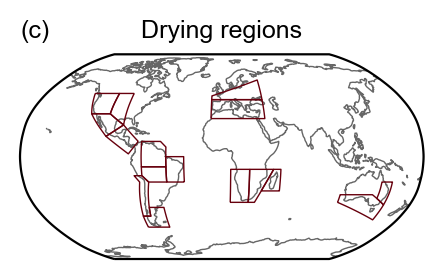

In [80]:
def plot_regions_report():
    f, ax = plot.map_subplots()

    # text_kws = dict(color="#67000d", fontsize=6, bbox=dict(pad=0.2, color="w"))

    ax = ar6_land_dpr.plot(
        #     text_kws=text_kws,
        label="abbrev",
        line_kws=dict(linewidth=0.5, color="#67000d"),
        ax=ax,
        add_label=False,
    )

    ax.set_title("Drying regions", fontsize=9)

    ax.set_title("(c)", fontsize=9, loc="left")

    ax.set_global()

    f.subplots_adjust(left=0.01, right=0.99, bottom=0.02, top=0.825)

    mpu.set_map_layout(ax, width=5.23)

    return ax

plot_regions_report()
fN = conf.cmip6.figure_filename(
    "Figure_11.18c_drought_prone_regions",
    "Figure_11.18_SM_drought_dpr",
    add_prefix=False,
)
plt.savefig(fN + ".png", dpi=300, transparent=False, facecolor="w")
plt.savefig(fN + ".pdf", dpi=300)

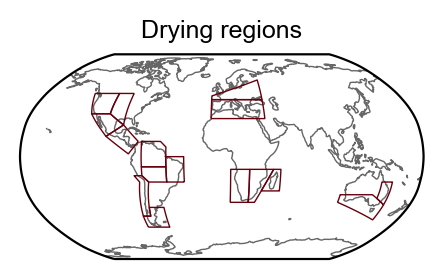

In [81]:
ax = plot_regions_report()

ax.set_title("", loc="left")

fN = conf.cmip6.figure_filename(
    "Figure_11.18_map",
    FIGURE_FOLDER_11_18,
    add_prefix=False,
)
plt.savefig(fN + ".png", dpi=300, transparent=False, facecolor="w")
plt.savefig(fN + ".pdf", dpi=300)

In [82]:
d_freq

quantile       0.50    0.17    0.83   0.05    0.95
warming_level                                     
0.84           1.70  1.0200  2.1658  0.680  3.7400
1.0            1.70  1.0200  2.3800  0.680  4.0800
1.5            2.04  1.1118  3.4000  1.020  5.1000
2.0            2.38  1.3600  4.0596  1.326  5.8310
3.0            3.23  2.0400  5.4400  1.360  7.6755
4.0            4.08  2.3800  6.3036  1.700  7.2080

In [83]:
d_freq_not_dpr.where(d_freq_not_dpr != 0, 0.0001)

quantile       0.50    0.17  0.83    0.05   0.95
warming_level                                   
0.84           1.02  0.3400  1.36  0.0001  1.717
1.0            1.02  0.3400  1.36  0.0001  2.040
1.5            0.68  0.0001  1.36  0.0001  2.040
2.0            0.68  0.0001  1.36  0.0001  2.040
3.0            0.68  0.0001  1.36  0.0001  2.380
4.0            1.02  0.1564  1.70  0.0001  2.414

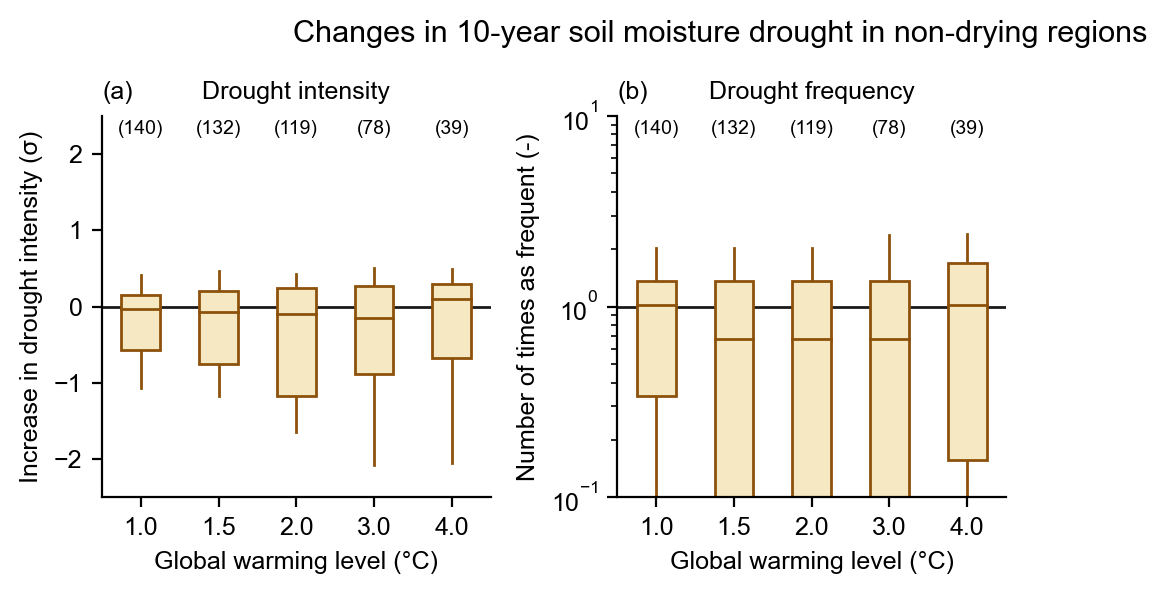

In [84]:
axes = boxplot_changes_in_drought(
    d_intensity_not_dpr,
    d_freq_not_dpr,
    "Changes in 10-year soil moisture drought in non-drying regions",
)

axes[0].set_ylim(-2.5, 2.5)

ax = axes[1]
ax.set_ylim(0.1, 10)

# ax.axhline(0)

ax.set_yscale('log')

fN = conf.cmip6.figure_filename(
    "Figure_11.18ab_SMDroughtIndex_dpr_intensity_frequency_NON_DRYING",
    FIGURE_FOLDER_11_18,
    add_prefix=False,
)
plt.savefig(fN + ".pdf", dpi=300)
plt.savefig(fN + ".png", dpi=300, transparent=False, facecolor="w")